In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

stock_symbol = "QQQ"
# Fetch data
today=datetime.today().strftime('%Y-%m-%d')
tomorrow = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

# Download training data (2020 - 2024)
train_start = "2014-01-01"
train_end = tomorrow
train_data = yf.download(stock_symbol, start=train_start, end=train_end, interval="1d",multi_level_index=False)

# Feature Engineering, multiple 100 to make it in 100%
# for data in [train_data, test_data]:
#     data["daily_change_%"] = data["Close"].pct_change() * 100
#     data["curday_change_%"] = (data["Close"] - data["Open"]) / data["Open"] * 100
train_data["daily_change_%"] = train_data["Close"].pct_change() * 100
train_data["curday_change_%"] = (train_data["Close"] - train_data["Open"]) / train_data["Open"] * 100
print(train_data.head())
train_data.tail()
# print(test_data.head())

[*********************100%***********************]  1 of 1 completed

                Close       High        Low       Open    Volume  \
Date                                                               
2014-01-02  79.544685  79.827248  79.316816  79.799905  29177500   
2014-01-03  78.970444  79.617592  78.952217  79.544672  35723700   
2014-01-06  78.678810  79.079863  78.387137  78.988716  32073100   
2014-01-07  79.407967  79.526456  78.897534  79.043374  25860600   
2014-01-08  79.581131  79.799891  79.252998  79.426181  27197400   

            daily_change_%  curday_change_%  
Date                                         
2014-01-02             NaN        -0.319825  
2014-01-03       -0.721911        -0.721894  
2014-01-06       -0.369295        -0.392342  
2014-01-07        0.926751         0.461256  
2014-01-08        0.218069         0.195086  


,Close,High,Low,Open,Volume,daily_change_%,curday_change_%
Date,,,,,,,
2025-02-18,539.369995,540.000000,536.039978,539.729980,20565000,0.226697,-0.066697
2025-02-19,539.520020,540.809998,536.460022,538.570007,19666900,0.027815,0.176395
2025-02-20,537.229980,539.099976,532.460022,538.729980,26550800,-0.424459,-0.278433
2025-02-21,526.080017,538.400024,525.710022,538.380005,46994900,-2.075454,-2.284629
2025-02-24,519.869995,529.068970,519.530029,527.919983,38129928,-1.180433,-1.524850


In [9]:
train_end

'2025-02-25'

In [10]:
# plt.figure(figsize=(16,6))
# plt.plot(train_data.index,train_data["daily_change_%"],label="daily return in %")
# plt.plot(train_data.index,train_data["curday_change_%"],label="cur day return in %")
# plt.title("daily returns")
# plt.xlabel("date")
# plt.legend()
# plt.show()
# diff graph
# fig,axes=plt.subplots(ncols=2,figsize=(12,6))
# axes[0].plot(train_data.index,train_data["daily_change_%"])
# axes[0].set_title("daily %")
# axes[0].set_xlabel("date")
# axes[0].set_ylabel("%")

# axes[1].plot(train_data.index,train_data["curday_change_%"])
# axes[1].set_title("daily %")
# axes[1].set_xlabel("date")
# axes[1].set_ylabel("%")

Text(0, 0.5, '%')

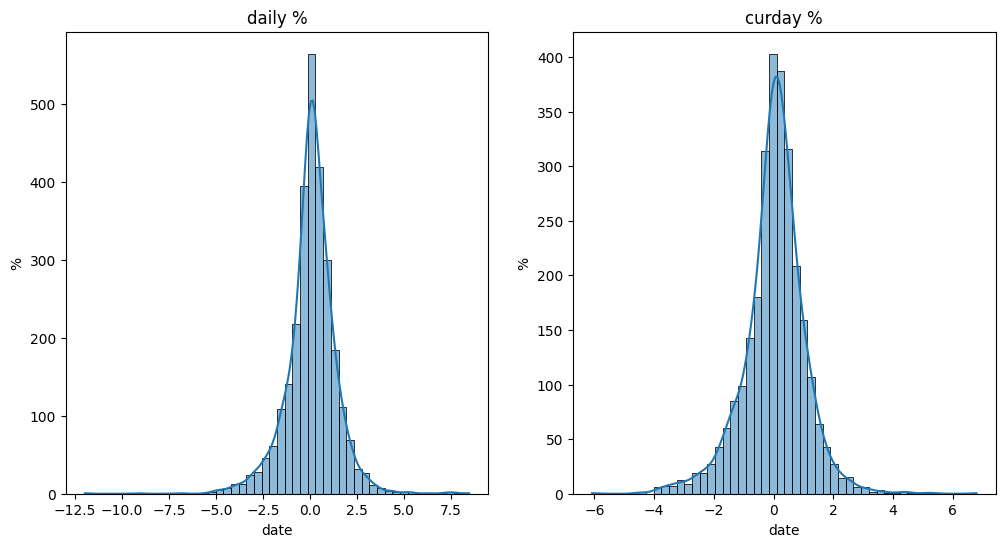

In [11]:
fig,axes=plt.subplots(ncols=2,figsize=(12,6))
sns.histplot(train_data["daily_change_%"],kde=True,bins=50,ax=axes[0])
axes[0].set_title("daily %")
axes[0].set_xlabel("date")
axes[0].set_ylabel("%")

sns.histplot(train_data["curday_change_%"],kde=True,bins=50,ax=axes[1])
axes[1].set_title("curday %")
axes[1].set_xlabel("date")
axes[1].set_ylabel("%")

- Data Inspection & Preparation
- Stationarity Check
- Mean Model Estimation (AR, ARMA, ARIMA)
- Residual Diagnostics & ARCH Testing
- Fitting an ARCH/GARCH Model
- Rolling Volatility Analysis and Forecasting

# Stationarity Check and defien return column


In [12]:
from statsmodels.tsa.stattools import adfuller

returns=train_data["daily_change_%"].dropna()
returns.index = pd.DatetimeIndex(returns.index).to_period('D')

ad_result=adfuller(returns)
print("adf stat: ",ad_result[0])
print(ad_result[1])
# A low p-value (typically < 0.05) 6.448207281113825e-30 indicates that the return series is stationary.

adf stat:  -17.3355482976773
5.378055637074194e-30


# Mean Model Estimation (AR, ARMA, ARIMA)

Text(0.5, 1.0, 'PACF')

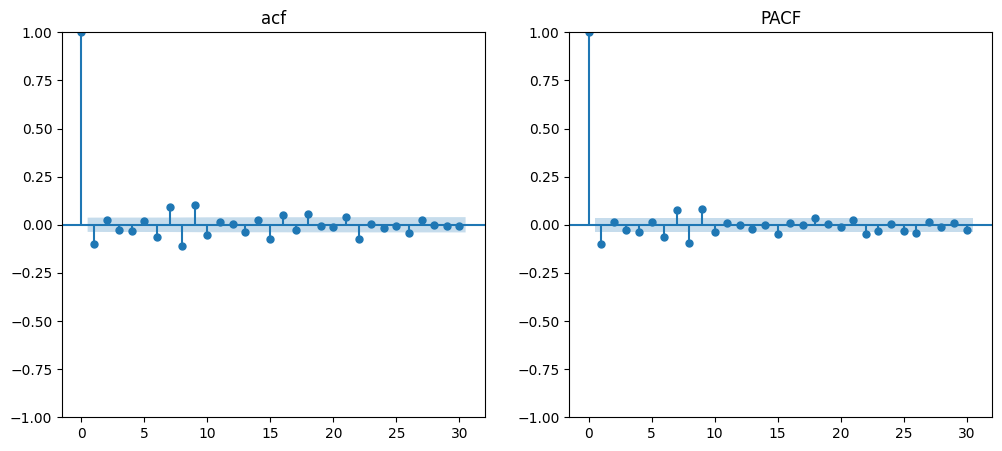

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(returns,ax=plt.gca(),lags=30)
plt.title("acf")
plt.subplot(122)
plot_pacf(returns,ax=plt.gca(),lags=30)
plt.title("PACF")
# no significant spike, indication of weak autocorrelation between differnt days' returns
# liekly rely on capture time-varying volatility via GARCH

- because the ACF/PACF show no strong autocorrelation, start with the simplest assumption: a constant mean (or even zero mean).
- Alternatively, suspect there might be a small but non-zero drift,  estimate a constant term, (use rolling mean to estimate it)


In [14]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Fit an AR(1) model:  assumes that today's return depends linearly on yesterday's return plus a constant and an error term.
ar_model = ARIMA(returns, order=(1, 0, 0)).fit()
print(ar_model.summary())

# Fit an ARMA(1,1) model: today's return to depend not only on yesterday's return but also on the previous period’s shock (error)
arma_model = ARIMA(returns, order=(1, 0, 1)).fit()
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:         daily_change_%   No. Observations:                 2802
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4768.938
Date:                Mon, 24 Feb 2025   AIC                           9543.877
Time:                        17:43:00   BIC                           9561.691
Sample:                    01-03-2014   HQIC                          9550.307
                         - 02-24-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0760      0.023      3.244      0.001       0.030       0.122
ar.L1         -0.0998      0.010     -9.968      0.000      -0.119      -0.080
sigma2         1.7613      0.026     67.774      0.0

In [15]:
# result 1
# Ljung-Box Q (lag 1 = 0.01, p=0.94):
# Indicates that the residuals do not show significant autocorrelation—i.e., the model has captured the serial correlation adequately.
# Jarque-Bera (JB = 3834.68, p=0.00):
# Suggests that the residuals are not normally distributed (a common finding in financial returns).
# Heteroskedasticity (H = 2.18, p=0.00):
# The p-value here indicates evidence of heteroskedasticity, which means that the variability of returns changes over time (volatility clustering).

# result 2
# Similar diagnostics (Ljung-Box, JB, Heteroskedasticity) indicate that both models leave residuals that are uncorrelated in mean but still display heteroskedasticity and non-normality

# exam the possible non zero mean 
- use rolling window mean to verify

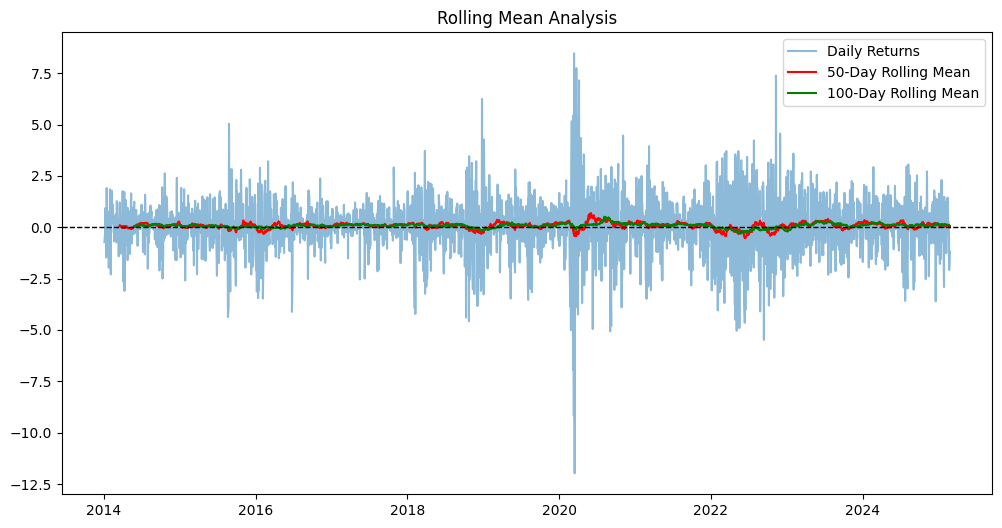

In [16]:
train_data["rolling_mean_50"] = train_data["daily_change_%"].rolling(window=50).mean()
train_data["rolling_mean_100"] = train_data["daily_change_%"].rolling(window=100).mean()

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data["daily_change_%"], label="Daily Returns", alpha=0.5)
plt.plot(train_data.index, train_data["rolling_mean_50"], label="50-Day Rolling Mean", color="red")
plt.plot(train_data.index, train_data["rolling_mean_100"], label="100-Day Rolling Mean", color="green")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.legend()
plt.title("Rolling Mean Analysis")
plt.show()


In [17]:
import scipy.stats as stats

sample_mean = train_data["daily_change_%"].mean()
sample_std = train_data["daily_change_%"].std()
n = len(train_data["daily_change_%"].dropna())
t_stat = sample_mean / (sample_std / np.sqrt(n))
p_value = stats.t.sf(np.abs(t_stat), df=n-1) * 2  # two-tailed test

print("Sample Mean:", sample_mean)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Sample Mean: 0.07655309553065086
# t-statistic: 3.0125534865009613
# p-value: 0.0026140789546682313

Sample Mean: 0.07594601192814454
t-statistic: 3.013457243937101
p-value: 0.002606029471571348


# Residual Diagnostics & ARCH Testing

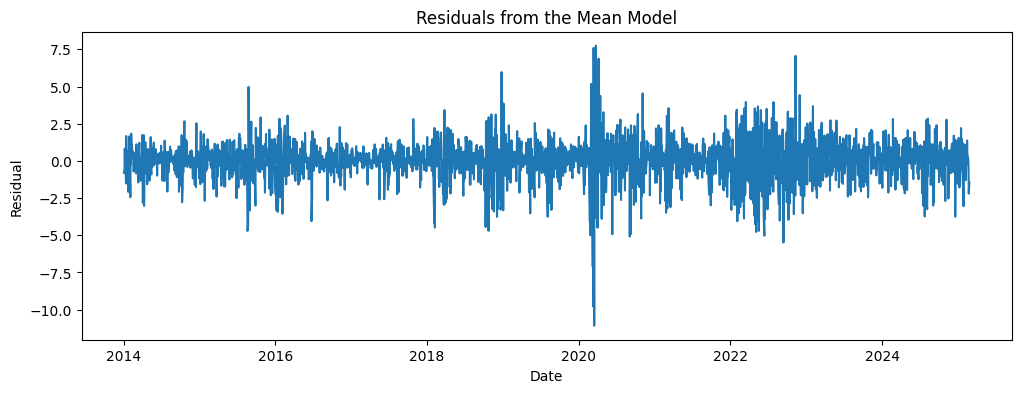

In [18]:
residuals=arma_model.resid
# residuals
# Convert PeriodIndex to Timestamp if necessary
residuals.index = residuals.index.to_timestamp()
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals from the Mean Model")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()
# pretty similar with original, since ARIMA didn't capture much information

In [19]:
# arch effect: checking whether there is autocorrelation in the squared residuals, 
# whether the variance of your residuals is time-dependent (a sign of volatility clustering).
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(residuals.dropna(), maxlag=10)
print("ARCH Test Statistic:", arch_test[0])
print("p-value:", arch_test[1])

ARCH Test Statistic: 717.4691119223726
p-value: 1.1150631880910524e-147


C:\Users\chenl\AppData\Local\Temp\ipykernel_20928\3072921746.py:5: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(residuals.dropna(), maxlag=10)


In [20]:
from arch import arch_model
garch_model=arch_model(residuals.dropna(),vol="Garch",p=1,q=1,dist='normal') # p=1: ARCH term from prior arima function, q=1 GARCH team, prior forecast t-1 variance value
garch_results = garch_model.fit(update_freq=5)
print(garch_results.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 4306.838415666638
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4306.751583869986
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4306.75
Distribution:                  Normal   AIC:                           8621.50
Method:            Maximum Likelihood   BIC:                           8645.26
                                        No. Observations:                 2802
Date:                Mon, Feb 24 2025   Df Residuals:                     2801
Time:                        17:43:01   Df Model:                            1
          

# test GARCH parameters

In [21]:
# Define ranges for p and q to test
p_values = range(1, 7)  # e.g., 1, 2, 3
q_values = range(1, 7)  # e.g., 1, 2, 3

results = []
for p in p_values:
    for q in q_values:
        try:
            # Fit the model (using mean='Zero' if the mean has been already modeled; otherwise, use the constant mean option)
            model = arch_model(residuals.dropna(), vol='Garch', p=p, q=q, mean='Zero', dist='normal')
            res = model.fit(update_freq=5, disp='off')
            
            # Record the results
            results.append({'p': p, 'q': q, 'AIC': res.aic, 'BIC': res.bic})
            print(f"GARCH({p},{q}) - AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")
        except Exception as e:
            print(f"GARCH({p},{q}) did not converge: {e}")

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print("\nSummary of models:")
print(results_df.sort_values('AIC'))
# garch 1,1 still the most appropriate model

GARCH(1,1) - AIC: 8623.33, BIC: 8641.14
GARCH(1,2) - AIC: 8625.33, BIC: 8649.08
GARCH(1,3) - AIC: 8627.33, BIC: 8657.02
GARCH(1,4) - AIC: 8629.33, BIC: 8664.96
GARCH(1,5) - AIC: 8631.33, BIC: 8672.89
GARCH(1,6) - AIC: 8633.33, BIC: 8680.83
GARCH(2,1) - AIC: 8625.32, BIC: 8649.08
GARCH(2,2) - AIC: 8627.30, BIC: 8656.99
GARCH(2,3) - AIC: 8628.54, BIC: 8664.17
GARCH(2,4) - AIC: 8630.54, BIC: 8672.11
GARCH(2,5) - AIC: 8632.54, BIC: 8680.05
GARCH(2,6) - AIC: 8634.54, BIC: 8687.98
GARCH(3,1) - AIC: 8626.51, BIC: 8656.20
GARCH(3,2) - AIC: 8628.38, BIC: 8664.01
GARCH(3,3) - AIC: 8629.84, BIC: 8671.41
GARCH(3,4) - AIC: 8631.84, BIC: 8679.35
GARCH(3,5) - AIC: 8633.84, BIC: 8687.29
GARCH(3,6) - AIC: 8635.84, BIC: 8695.23
GARCH(4,1) - AIC: 8628.01, BIC: 8663.64
GARCH(4,2) - AIC: 8627.60, BIC: 8669.16
GARCH(4,3) - AIC: 8629.60, BIC: 8677.10
GARCH(4,4) - AIC: 8631.60, BIC: 8685.04
GARCH(4,5) - AIC: 8633.59, BIC: 8692.97
GARCH(4,6) - AIC: 8635.42, BIC: 8700.74
GARCH(5,1) - AIC: 8630.01, BIC: 8671.58


# Rolling Volatility Analysis and Forecasting

In [ ]:
# Assume 'returns' is your returns series with a DateTimeIndex
rolling_window = 2000
forecasted_vols = []
realized_abs_errors = []

# We need to leave one extra day for the "next day" actual return, so iterate until len(returns)-1
for i in range(rolling_window, len(returns) - 1):
    # Use a rolling window of returns
    window_data = returns.iloc[i - rolling_window : i]
    
    # Fit an ARIMA model for the mean on the window
    arma_window = ARIMA(window_data, order=(1, 0, 1)).fit()
    res_window = arma_window.resid
    
    # Fit a GARCH(1,1) model on the ARIMA residuals
    garch_window = arch_model(res_window.dropna(), vol='Garch', p=1, q=1, dist='normal')
    garch_window_results = garch_window.fit(disp="off")
    
    # Forecast next day volatility (variance) using the GARCH model
    forecast = garch_window_results.forecast(horizon=1)
    next_day_var = forecast.variance.iloc[-1, 0]
    next_day_vol = np.sqrt(next_day_var)
    forecasted_vols.append(next_day_vol)
    
    # Forecast the next day mean return from the ARIMA model
    arma_forecast = arma_window.forecast(steps=1)
    next_day_forecast_mean = arma_forecast.iloc[0]
    
    # Get the actual next day return (out-of-sample)
    next_day_actual = returns.iloc[i]
    
    # Compute realized absolute error: the absolute deviation from the forecasted mean
    realized_error = abs(next_day_actual - next_day_forecast_mean)
    realized_abs_errors.append(realized_error)

In [ ]:
# Create a date index for the forecasts; using the index from the returns after the window
forecast_dates = returns.index[rolling_window : len(returns) - 1]

# Convert the forecasted results to a pandas Series
forecasted_vols_series = pd.Series(forecasted_vols, index=forecast_dates)
realized_errors_series = pd.Series(realized_abs_errors, index=forecast_dates)

forecasted_vols_series.index = forecasted_vols_series.index.to_timestamp()
realized_errors_series.index = realized_errors_series.index.to_timestamp()

# Plot the forecasted volatility vs. the realized absolute error
plt.figure(figsize=(12, 6))
plt.plot(forecasted_vols_series, label="Forecasted 1-Day Volatility (GARCH)")
plt.plot(realized_errors_series, label="Realized Absolute Error", alpha=0.7)
plt.title("Forecasted Volatility vs. Realized Absolute Error")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
errors = forecasted_vols_series - realized_errors_series  # assuming these are aligned
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# call function to forecast tomorrow 
yfinance call in step 1 involve date's return

In [ ]:
# Assume 'returns' is your returns series with a proper DateTimeIndex
# The last index value is your "most recent" date in the dataset
last_period = returns.index[-1]

# Convert it to a Timestamp
last_date = last_period.to_timestamp()

# Calculate the "tomorrow" date.
# For calendar days:
tomorrow_date = last_date + pd.Timedelta(days=1)

# 1) Fit ARIMA model on the entire dataset
arima_model = ARIMA(returns, order=(1, 0, 1)).fit()

# 2) Extract residuals
residuals = arima_model.resid.dropna()

# 3) Fit GARCH(1,1) on those residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, dist='normal', mean='Zero')
garch_results = garch_model.fit(disp='off')

# 4) Forecast for the next day
arima_forecast = arima_model.forecast(steps=1)
tomorrow_mean = arima_forecast.iloc[0]

garch_forecast = garch_results.forecast(horizon=1)
tomorrow_var = garch_forecast.variance.iloc[-1, 0]
tomorrow_vol = np.sqrt(tomorrow_var)

# Print your forecast, including the calculated "tomorrow_date"
print(f"Forecast for {tomorrow_date.date()}:")
print(f"  Mean Return (ARIMA): {tomorrow_mean:.4f}")
print(f"  Volatility (GARCH):  {tomorrow_vol:.4f}")
